# Credit Risk Classifier - Neural Networks

----

### The Data

We will be using a subset of the LendingClub data set obtained from Kaggle. The original dataset can be found at: https://www.kaggle.com/wordsforthewise/lending-club. The "loan_status" column contains our label (or classes used for the classification task). **NOTE: We are working with a special version of this data set that has some extra feature engineering requirements.**

### Background

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

### Project Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model that can predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. We will use typical classification metrics when evaluating the performance of our model.

----

In [1]:
# load all the libraries and packages used in this notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# configure user settings
%config Completer.use_jedi = False

In [73]:
# load specific functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import random

### Load the Pre-processed Data Set

In [19]:
# df = pd.read_csv('./data/lending_club_clean_dummies.csv')
# df = pd.read_csv('./data/lending_club_clean_dummies_balanced.csv')
df = pd.read_csv('./data/lending_club_course.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395219 entries, 0 to 395218
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   dti                                  395219 non-null  float64
 6   earliest_cr_line                     395219 non-null  int64  
 7   open_acc                             395219 non-null  float64
 8   pub_rec                              395219 non-null  float64
 9   revol_bal                            395219 non-null  float64
 10  revol_util                           395219 non-null  float64
 11  total_acc    

### Balancing the Output Labels

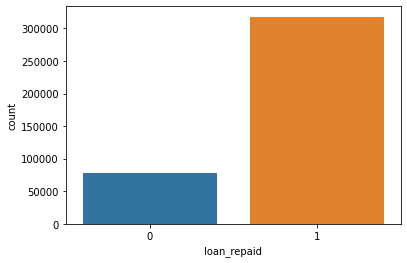

In [23]:
# we have more instances of loans being fully paid than being charged off
sns.countplot(data=df, x='loan_repaid');

In [24]:
df_paid = df[ df['loan_repaid'] == 1 ]
df_default = df[ df['loan_repaid'] == 0 ]

In [25]:
n_default = len(df_default)
n_default

77523

In [26]:
df_sample = df_paid.sample(n=n_default, random_state=101)
len(df_sample)

77523

In [28]:
df_bal = pd.concat([df_default, df_sample], axis=0)
df_bal = df_bal.sample(frac=1, random_state=101)
df_bal.reset_index(inplace=True, drop=True)
df_bal

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,RENT,05113,11650,22690,29597,30723,48052,70466,86630,93700
0,12000.0,60,17.57,301.93,60000.0,8.82,1999,10.0,1.0,6422.0,...,1,0,0,0,0,0,0,1,0,0
1,20000.0,36,7.69,623.88,90000.0,11.31,1965,14.0,0.0,37464.0,...,0,0,0,0,0,0,0,1,0,0
2,13000.0,36,11.67,429.74,54312.0,33.19,2003,15.0,0.0,9697.0,...,0,1,0,0,0,0,0,0,0,0
3,12000.0,36,16.99,427.78,60000.0,24.46,2001,11.0,0.0,19564.0,...,0,0,0,0,0,1,0,0,0,0
4,32000.0,36,11.67,1057.83,144000.0,19.49,1976,14.0,0.0,41069.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155041,35000.0,36,12.12,1164.51,167200.0,19.90,1969,18.0,0.0,24288.0,...,0,0,0,0,1,0,0,0,0,0
155042,18000.0,36,11.99,597.78,165000.0,9.18,2001,11.0,0.0,46648.0,...,0,0,0,1,0,0,0,0,0,0
155043,20000.0,36,12.49,668.98,65000.0,24.45,1996,21.0,0.0,23008.0,...,0,0,0,0,0,0,0,1,0,0
155044,5800.0,36,13.11,195.74,20000.0,28.44,2003,12.0,0.0,10958.0,...,1,0,0,0,0,0,1,0,0,0


In [29]:
df_bal.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'loan_repaid', 'A2',
       'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4',
       'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1',
       'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'OTHER', 'OWN', 'RENT', '05113',
       '11650',

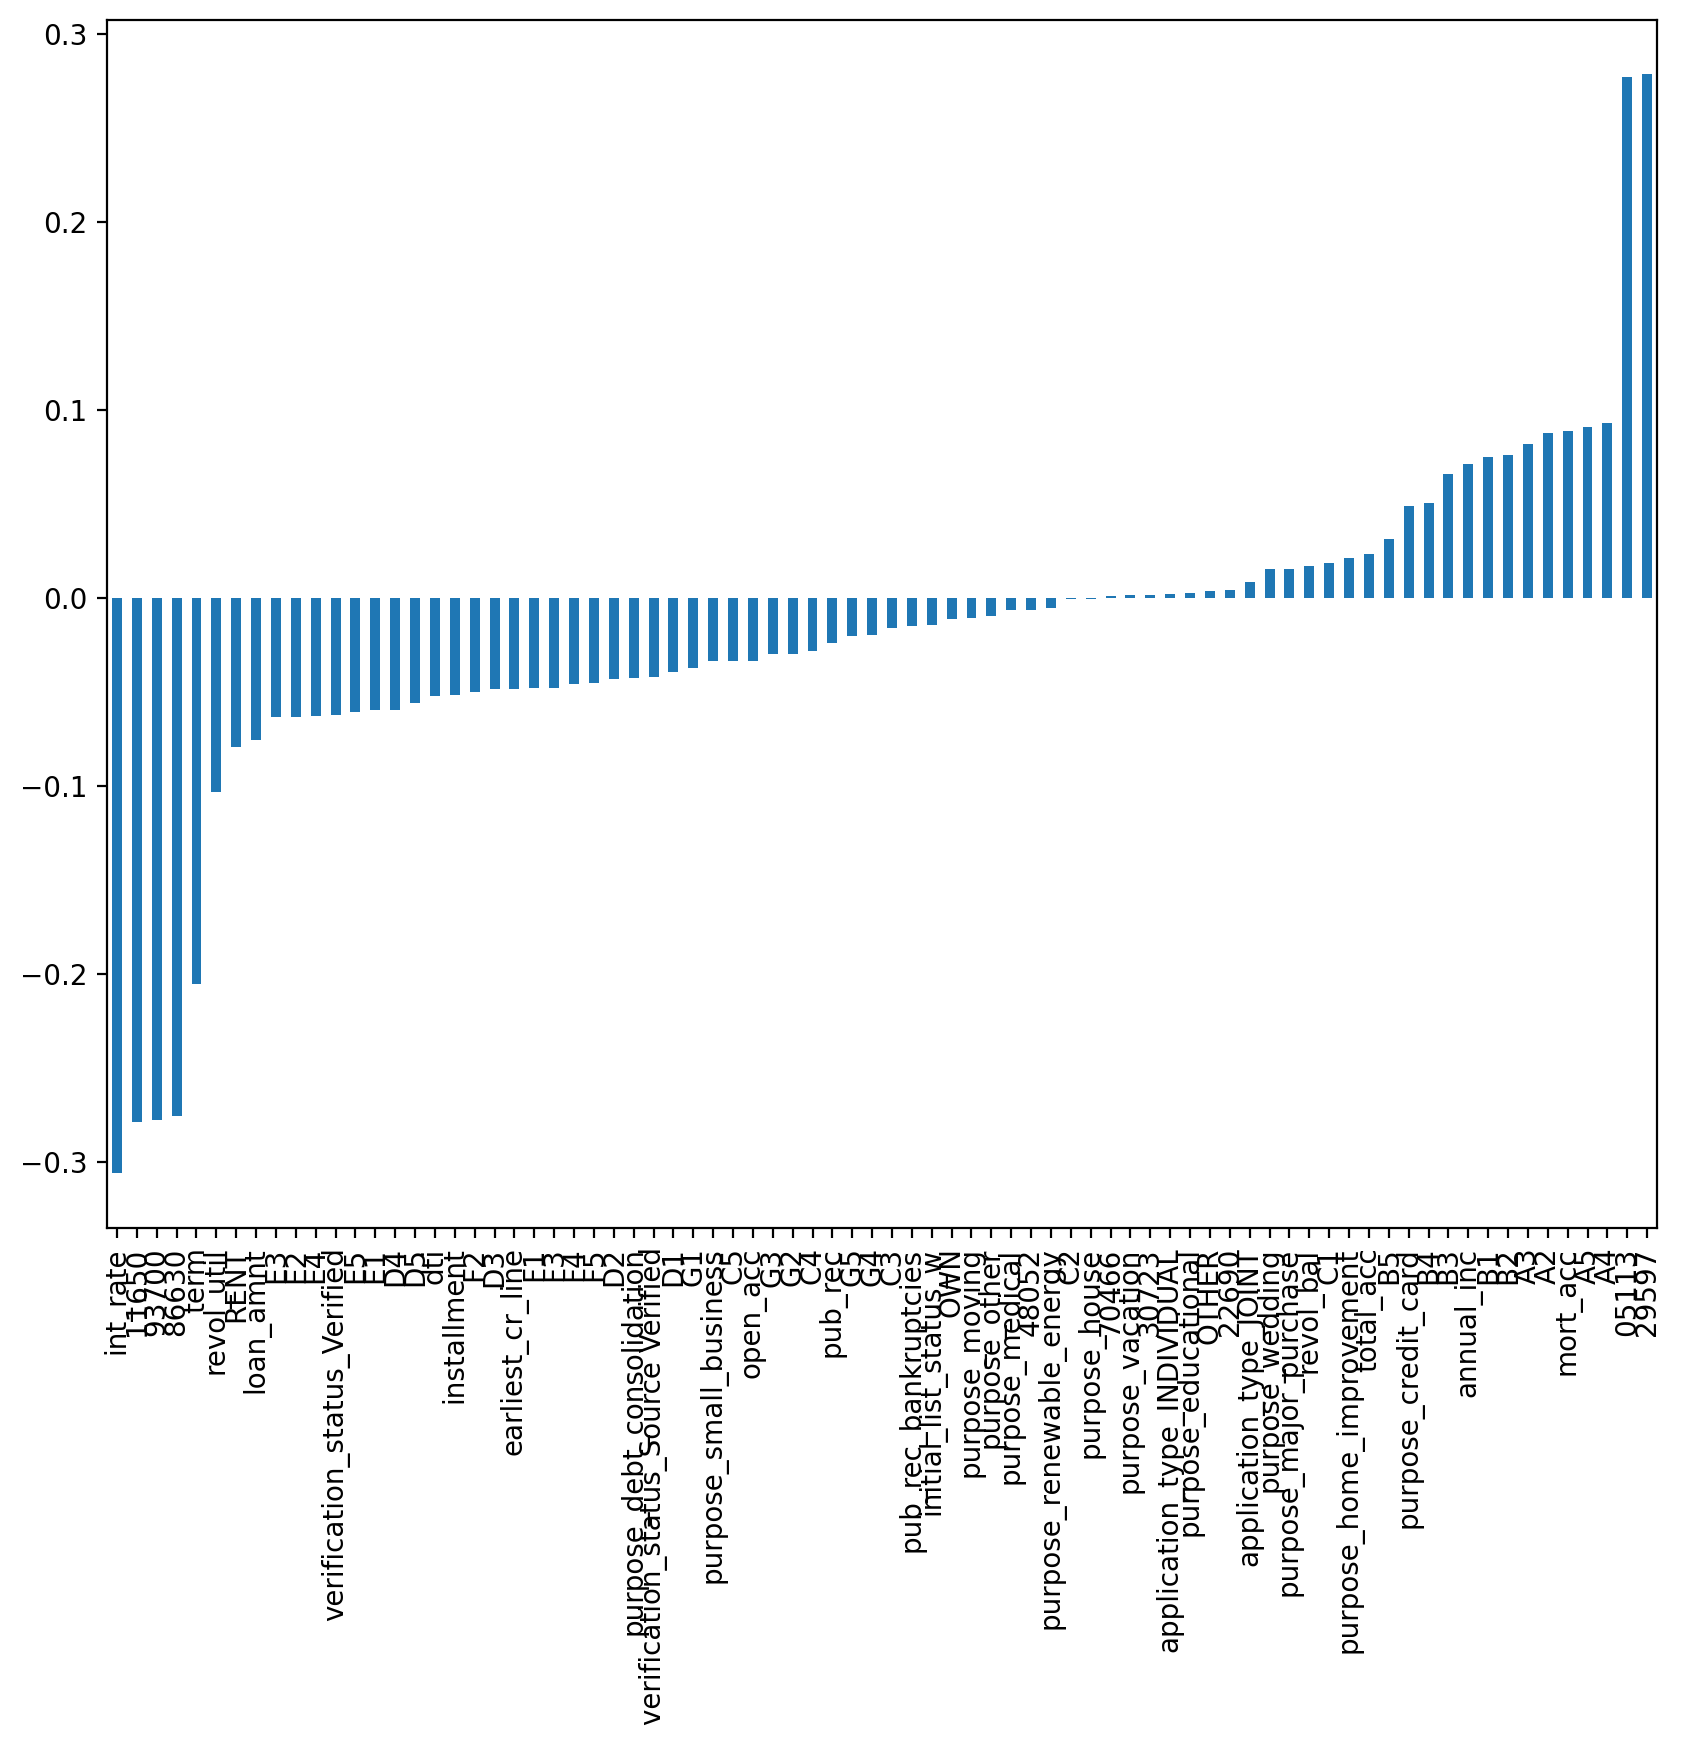

In [33]:
plt.figure(figsize=(10,8), dpi=200)
df_bal.corr()['loan_repaid'].sort_values()[:-1].plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

### Split the Data for Modeling

In [34]:
# X = df.drop('loan_status', axis=1)
# y = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

X = df_bal.drop('loan_repaid', axis=1)
y = df_bal['loan_repaid']

In [35]:
X.shape

(155046, 78)

In [36]:
y.shape

(155046,)

In [37]:
# train-validation-test split: 80-10-10

# SPLIT #1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.10, random_state=101)

# SPLIT #2
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=101)

In [39]:
X_train.shape

(139541, 78)

In [40]:
X_valid.shape

(7752, 78)

In [41]:
X_test.shape

(7753, 78)

### Scale the Input Data

In [42]:
# OPTION 1: use the standard scaler
scaler_1 = StandardScaler()
X_train_1 = scaler_1.fit_transform(X_train)
X_valid_1 = scaler_1.transform(X_valid)
X_test_1 = scaler_1.transform(X_test)

In [43]:
# OPTION 1: use the min-max scaler
scaler_2 = MinMaxScaler()
X_train_2 = scaler_2.fit_transform(X_train)
X_valid_2 = scaler_2.transform(X_valid)
X_test_2 = scaler_2.transform(X_test)

### Model 1: Training

* (put details about the model here)

In [54]:
input_shape = X_train_2.shape[1]
input_shape

78

In [55]:
# initialize model
model_1 = Sequential()
dropout_rate = 0.25

# input layer
model_1.add(Dense(input_shape, activation='relu'))
model_1.add(Dropout(dropout_rate))

# hidden layer(s)
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(dropout_rate))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(dropout_rate))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(dropout_rate))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(dropout_rate))

# output layer
model_1.add(Dense(units=1, activation='sigmoid'))

# compile model
model_1.compile(loss='binary_crossentropy', optimizer='adam')

In [56]:
# choose min because we want to minimize the loss (or error); for accuracy, use max
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=2, 
                           patience=25)

In [57]:
# train the NN model
model_1.fit(x=X_train_2, y=y_train,
            epochs=512,
            batch_size=128,
            validation_data=(X_valid_2, y_valid),
            callbacks=[early_stop],
            verbose=2)

Epoch 1/512
1091/1091 - 10s - loss: 0.4152 - val_loss: 0.3656
Epoch 2/512
1091/1091 - 8s - loss: 0.3674 - val_loss: 0.3658
Epoch 3/512
1091/1091 - 8s - loss: 0.3645 - val_loss: 0.3636
Epoch 4/512
1091/1091 - 7s - loss: 0.3631 - val_loss: 0.3638
Epoch 5/512
1091/1091 - 7s - loss: 0.3628 - val_loss: 0.3629
Epoch 6/512
1091/1091 - 8s - loss: 0.3614 - val_loss: 0.3619
Epoch 7/512
1091/1091 - 8s - loss: 0.3613 - val_loss: 0.3620
Epoch 8/512
1091/1091 - 8s - loss: 0.3603 - val_loss: 0.3622
Epoch 9/512
1091/1091 - 9s - loss: 0.3600 - val_loss: 0.3612
Epoch 10/512
1091/1091 - 8s - loss: 0.3595 - val_loss: 0.3600
Epoch 11/512
1091/1091 - 8s - loss: 0.3592 - val_loss: 0.3607
Epoch 12/512
1091/1091 - 7s - loss: 0.3592 - val_loss: 0.3615
Epoch 13/512
1091/1091 - 7s - loss: 0.3585 - val_loss: 0.3609
Epoch 14/512
1091/1091 - 7s - loss: 0.3582 - val_loss: 0.3612
Epoch 15/512
1091/1091 - 7s - loss: 0.3584 - val_loss: 0.3609
Epoch 16/512
1091/1091 - 7s - loss: 0.3573 - val_loss: 0.3602
Epoch 17/512
109

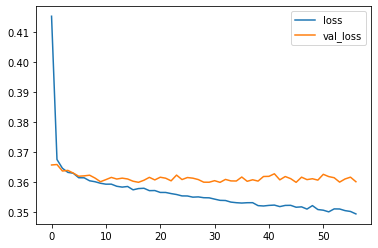

In [58]:
# evaluate the loss for training and validation data
losses_1 = pd.DataFrame(model_1.history.history)
losses_1.plot()
plt.show()

### Model 1: Evaluation

In [65]:
y_test_pred = (model_1.predict(X_test_2) > 0.5).astype('int32')
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3903
           1       0.80      0.78      0.79      3850

    accuracy                           0.80      7753
   macro avg       0.80      0.80      0.80      7753
weighted avg       0.80      0.80      0.80      7753



In [67]:
y_valid_pred = (model_1.predict(X_valid_2) > 0.5).astype('int32')
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3868
           1       0.81      0.78      0.80      3884

    accuracy                           0.80      7752
   macro avg       0.80      0.80      0.80      7752
weighted avg       0.80      0.80      0.80      7752



### Model 1: Predictions

In [80]:
random.seed(101)
random_index = random.randint(0, len(df_bal))

new_client = df_bal.drop('loan_repaid', axis=1).iloc[random_index]
new_client

loan_amnt      20000.00
term              36.00
int_rate          13.98
installment      683.36
annual_inc     60000.00
                 ...   
30723              0.00
48052              0.00
70466              0.00
86630              0.00
93700              1.00
Name: 152345, Length: 78, dtype: float64

In [81]:
x = scaler_2.transform(new_client.values.reshape(1, input_shape))

In [84]:
(model_1.predict_classes(x) > 0.5).astype('int32')

array([[0]])

In [86]:
df_bal.iloc[random_index]['loan_repaid']

0.0

### Model 2: Training

* (put details about the model here)

In [68]:
input_shape = X_train_2.shape[1]
input_shape

78

In [69]:
# initialize model
model_2 = Sequential()
dropout_rate = 0.4

# input layer
model_2.add(Dense(input_shape, activation='relu'))
model_2.add(Dropout(dropout_rate))

# hidden layer(s)
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(dropout_rate))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(dropout_rate))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(dropout_rate))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(dropout_rate))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(dropout_rate))

# output layer
model_2.add(Dense(units=1, activation='sigmoid'))

# compile model
model_2.compile(loss='binary_crossentropy', optimizer='adam')

In [70]:
# choose min because we want to minimize the loss (or error); for accuracy, use max
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=2, 
                           patience=16)

In [71]:
# train the NN model
model_2.fit(x=X_train_2, y=y_train,
            epochs=512,
            batch_size=128,
            validation_data=(X_valid_2, y_valid),
            callbacks=[early_stop],
            verbose=2)

Epoch 1/512
1091/1091 - 13s - loss: 0.4457 - val_loss: 0.3694
Epoch 2/512
1091/1091 - 11s - loss: 0.3748 - val_loss: 0.3699
Epoch 3/512
1091/1091 - 11s - loss: 0.3702 - val_loss: 0.3652
Epoch 4/512
1091/1091 - 11s - loss: 0.3694 - val_loss: 0.3675
Epoch 5/512
1091/1091 - 11s - loss: 0.3674 - val_loss: 0.3668
Epoch 6/512
1091/1091 - 11s - loss: 0.3668 - val_loss: 0.3650
Epoch 7/512
1091/1091 - 11s - loss: 0.3668 - val_loss: 0.3631
Epoch 8/512
1091/1091 - 11s - loss: 0.3661 - val_loss: 0.3653
Epoch 9/512
1091/1091 - 11s - loss: 0.3660 - val_loss: 0.3643
Epoch 10/512
1091/1091 - 11s - loss: 0.3649 - val_loss: 0.3649
Epoch 11/512
1091/1091 - 11s - loss: 0.3656 - val_loss: 0.3629
Epoch 12/512
1091/1091 - 11s - loss: 0.3649 - val_loss: 0.3652
Epoch 13/512
1091/1091 - 11s - loss: 0.3653 - val_loss: 0.3635
Epoch 14/512
1091/1091 - 11s - loss: 0.3638 - val_loss: 0.3633
Epoch 15/512
1091/1091 - 11s - loss: 0.3642 - val_loss: 0.3626
Epoch 16/512
1091/1091 - 11s - loss: 0.3641 - val_loss: 0.3624
E

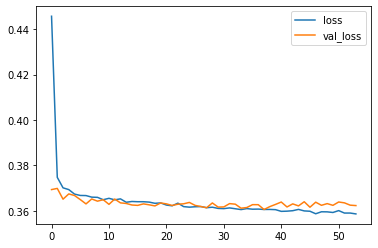

In [72]:
# evaluate the loss for training and validation data
losses_2 = pd.DataFrame(model_2.history.history)
losses_2.plot()
plt.show()

### Model 2: Evaluation

In [75]:
y_test_pred = (model_2.predict(X_test_2) > 0.5).astype('int32')
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3903
           1       0.79      0.80      0.80      3850

    accuracy                           0.80      7753
   macro avg       0.80      0.80      0.80      7753
weighted avg       0.80      0.80      0.80      7753



### Model 3: Training

In [87]:
input_shape = X_train_1.shape[1]
input_shape

78

In [88]:
# initialize model
model_3 = Sequential()
dropout_rate = 0.5

# input layer
model_3.add(Dense(input_shape, activation='relu'))
model_3.add(Dropout(dropout_rate))

# hidden layer(s)
model_3.add(Dense(40, activation='relu'))
model_3.add(Dropout(dropout_rate))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dropout(dropout_rate))

# output layer
model_3.add(Dense(units=1, activation='sigmoid'))

# compile model
model_3.compile(loss='binary_crossentropy', optimizer='adam')

In [89]:
# choose min because we want to minimize the loss (or error); for accuracy, use max
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=2, 
                           patience=16)

In [90]:
# train the NN model
model_3.fit(x=X_train_1, y=y_train,
            epochs=512,
            batch_size=128,
            validation_data=(X_valid_1, y_valid),
            callbacks=[early_stop],
            verbose=2)

Epoch 1/512
1091/1091 - 7s - loss: 0.5121 - val_loss: 0.3801
Epoch 2/512
1091/1091 - 5s - loss: 0.3903 - val_loss: 0.3668
Epoch 3/512
1091/1091 - 5s - loss: 0.3747 - val_loss: 0.3637
Epoch 4/512
1091/1091 - 5s - loss: 0.3693 - val_loss: 0.3601
Epoch 5/512
1091/1091 - 5s - loss: 0.3671 - val_loss: 0.3602
Epoch 6/512
1091/1091 - 5s - loss: 0.3659 - val_loss: 0.3589
Epoch 7/512
1091/1091 - 5s - loss: 0.3649 - val_loss: 0.3573
Epoch 8/512
1091/1091 - 6s - loss: 0.3631 - val_loss: 0.3588
Epoch 9/512
1091/1091 - 5s - loss: 0.3630 - val_loss: 0.3581
Epoch 10/512
1091/1091 - 6s - loss: 0.3627 - val_loss: 0.3585
Epoch 11/512
1091/1091 - 6s - loss: 0.3620 - val_loss: 0.3581
Epoch 12/512
1091/1091 - 5s - loss: 0.3618 - val_loss: 0.3574
Epoch 13/512
1091/1091 - 2s - loss: 0.3610 - val_loss: 0.3563
Epoch 14/512
1091/1091 - 2s - loss: 0.3603 - val_loss: 0.3548
Epoch 15/512
1091/1091 - 2s - loss: 0.3598 - val_loss: 0.3567
Epoch 16/512
1091/1091 - 2s - loss: 0.3603 - val_loss: 0.3581
Epoch 17/512
1091

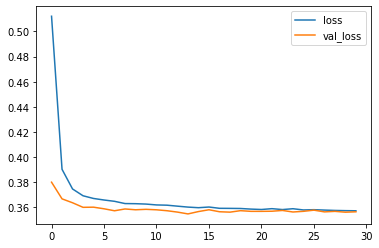

In [91]:
# evaluate the loss for training and validation data
losses_3 = pd.DataFrame(model_3.history.history)
losses_3.plot()
plt.show()

### Model 3: Evaluation

In [92]:
y_test_pred = (model_3.predict(X_test_1) > 0.5).astype('int32')
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3903
           1       0.80      0.79      0.80      3850

    accuracy                           0.80      7753
   macro avg       0.80      0.80      0.80      7753
weighted avg       0.80      0.80      0.80      7753



# Reduced Data Set

In [93]:
df2 = pd.read_csv('./data/lending_data_small_removed_outliers.csv')
df2

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,G4,G5,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,OTHER,OWN,RENT
0,10000.0,36,11.44,329.48,117000.0,26.24,1990,16.0,0.0,36369.0,...,0,0,0,0,1,0,1,0,0,1
1,8000.0,36,11.99,265.68,65000.0,22.05,2004,17.0,0.0,20131.0,...,0,0,0,0,1,0,0,0,0,0
2,15600.0,36,10.49,506.97,43057.0,12.79,2007,13.0,0.0,11987.0,...,0,0,1,0,1,0,0,0,0,1
3,7200.0,36,6.49,220.65,54000.0,2.60,2006,6.0,0.0,5472.0,...,0,0,0,0,1,0,0,0,0,1
4,24375.0,60,17.27,609.33,55000.0,33.95,1999,13.0,0.0,24584.0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394721,10000.0,60,10.99,217.38,40000.0,15.63,2004,6.0,0.0,1990.0,...,0,0,1,0,1,0,1,0,0,1
394722,21000.0,36,12.29,700.42,110000.0,21.45,2006,6.0,0.0,43263.0,...,0,0,1,0,1,0,0,0,0,0
394723,5000.0,36,9.99,161.32,56500.0,17.56,1997,15.0,0.0,32704.0,...,0,0,0,1,1,0,0,0,0,1
394724,21000.0,60,15.31,503.02,64000.0,15.88,1990,9.0,0.0,15704.0,...,0,0,0,1,1,0,0,0,0,0


In [94]:
df2.isnull().sum()

loan_amnt                              0
term                                   0
int_rate                               0
installment                            0
annual_inc                             0
dti                                    0
earliest_cr_line                       0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
mort_acc                               0
pub_rec_bankruptcies                   0
loan_repaid                            0
A2                                     0
A3                                     0
A4                                     0
A5                                     0
B1                                     0
B2                                     0
B3                                     0
B4                                     0
B5                                     0
C1              

## Balance the Data Set

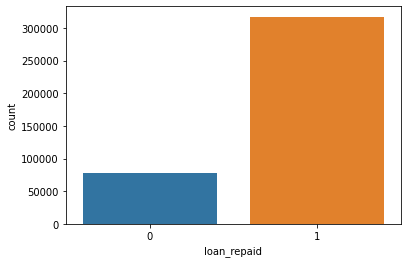

In [95]:
# we have more instances of loans being fully paid than being charged off
sns.countplot(data=df2, x='loan_repaid');

In [98]:
df_paid = df2[ df2['loan_repaid'] == 1 ]
df_default = df2[ df2['loan_repaid'] == 0 ]

In [99]:
n_default = len(df_default)
n_default

77457

In [100]:
df_sample = df_paid.sample(n=n_default, random_state=101)
len(df_sample)

77457

In [101]:
df_bal2 = pd.concat([df_default, df_sample], axis=0)
df_bal2 = df_bal2.sample(frac=1, random_state=101)
df_bal2.reset_index(inplace=True, drop=True)
df_bal2

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,...,G4,G5,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_w,OTHER,OWN,RENT
0,15000.0,36,6.17,375.91,99000.0,7.67,1998,12.0,0.0,2374.0,...,0,0,0,0,1,0,0,0,0,0
1,25975.0,60,24.08,748.46,65000.0,23.84,2003,19.0,0.0,21603.0,...,0,0,1,0,1,0,0,0,0,0
2,21000.0,36,7.90,657.10,240000.0,21.31,1998,16.0,0.0,222543.0,...,0,0,0,1,1,0,0,0,0,0
3,14400.0,36,13.11,485.96,50000.0,26.09,1998,9.0,0.0,7333.0,...,0,0,0,0,1,0,0,0,0,1
4,15000.0,60,17.57,377.41,85000.0,18.31,2002,9.0,0.0,6188.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154909,3000.0,36,18.99,109.96,37000.0,24.91,2002,15.0,0.0,8288.0,...,0,0,1,0,1,0,0,0,0,0
154910,11650.0,36,9.76,374.61,70720.0,29.34,1996,11.0,0.0,10510.0,...,0,0,0,1,1,0,0,0,0,0
154911,16000.0,60,15.61,385.79,65500.0,20.59,2001,18.0,0.0,7882.0,...,0,0,1,0,1,0,1,0,0,1
154912,15000.0,36,14.65,517.42,56000.0,14.34,1996,8.0,0.0,17225.0,...,0,0,1,0,1,0,0,0,0,0


### Split the Data for Modeling

In [102]:
X = df_bal2.drop('loan_repaid', axis=1)
y = df_bal2['loan_repaid']

In [103]:
X.shape

(154914, 56)

In [104]:
y.shape

(154914,)

In [105]:
# train-validation-test split: 80-10-10

# SPLIT #1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=101)

# SPLIT #2
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=101)

In [106]:
X_train.shape

(123931, 56)

In [107]:
X_valid.shape

(15491, 56)

In [108]:
X_test.shape

(15492, 56)

In [109]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Building and Training the NN Model

In [112]:
# input variables
input_shape = X_train.shape[1]  # (do not change)
dropout_rate = 0.5   # typical values between 0.2 and 0.5

# initialize model
model = Sequential()

# input layer
model.add(Dense(input_shape, activation='relu'))
model.add(Dropout(dropout_rate))

# hidden layer(s)
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [113]:
# choose min because we want to minimize the loss (or error); for accuracy, use max
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=2, 
                           patience=20)

In [114]:
# train the NN model
model.fit(x=X_train, y=y_train,
          epochs=256,
          batch_size=128,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stop],
          verbose=2)

Epoch 1/256
969/969 - 2s - loss: 0.6921 - val_loss: 0.6643
Epoch 2/256
969/969 - 1s - loss: 0.6542 - val_loss: 0.6432
Epoch 3/256
969/969 - 1s - loss: 0.6446 - val_loss: 0.6396
Epoch 4/256
969/969 - 1s - loss: 0.6407 - val_loss: 0.6357
Epoch 5/256
969/969 - 1s - loss: 0.6386 - val_loss: 0.6328
Epoch 6/256
969/969 - 1s - loss: 0.6378 - val_loss: 0.6315
Epoch 7/256
969/969 - 1s - loss: 0.6362 - val_loss: 0.6301
Epoch 8/256
969/969 - 1s - loss: 0.6352 - val_loss: 0.6281
Epoch 9/256
969/969 - 1s - loss: 0.6342 - val_loss: 0.6221
Epoch 10/256
969/969 - 1s - loss: 0.6337 - val_loss: 0.6263
Epoch 11/256
969/969 - 1s - loss: 0.6330 - val_loss: 0.6295
Epoch 12/256
969/969 - 1s - loss: 0.6335 - val_loss: 0.6289
Epoch 13/256
969/969 - 1s - loss: 0.6329 - val_loss: 0.6297
Epoch 14/256
969/969 - 1s - loss: 0.6319 - val_loss: 0.6265
Epoch 15/256
969/969 - 1s - loss: 0.6320 - val_loss: 0.6223
Epoch 16/256
969/969 - 1s - loss: 0.6317 - val_loss: 0.6272
Epoch 17/256
969/969 - 1s - loss: 0.6313 - val_lo

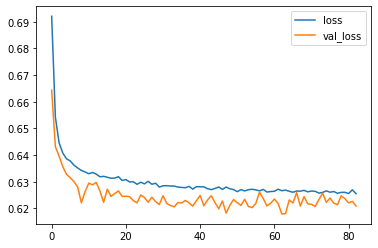

In [115]:
# evaluate the loss for training and validation data
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

## Model Evaluation

In [116]:
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66      7766
           1       0.65      0.66      0.66      7726

    accuracy                           0.66     15492
   macro avg       0.66      0.66      0.66     15492
weighted avg       0.66      0.66      0.66     15492

